# Passing Networks

This code creates a passing network for only forward passes made by Sweden in the 2019 Women's World Cup.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [15]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(69301)

In [16]:
# check for index of first sub
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "England Women's"].iloc[0]["index"]
# df with only sucessful forward passes by England until first sub
mask_england = (df.type_name == 'Pass') & (df.team_name == "England Women's") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in") & (df.end_x > df.x)
# pull necessary columns
df_pass = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
# adjust to only print last name (split name by spaces and take only last part)
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [17]:
scatter_df = pd.DataFrame()

# enumerate turns the data into something we can loop through
for i, name in enumerate(df_pass["player_name"].unique()):

    # make arrays for all of the starting/ending points of passes made by a particular player
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()

    # add each name at row i in player_name column to be the last name
    scatter_df.at[i, "player_name"] = name
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    # calculate number of passes (use .iloc to return only the first value, since .count() returns a series)
    scatter_df.at[i, "num"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# adjust the size of the circle to match larger circle for players that made more passes
scatter_df['marker_size'] = (scatter_df["num"] / scatter_df["num"].max() * 1500)

In [18]:
# create new column for key of player/recipient names regardless of order, join with underscore
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
# group by player/recipient pairs, count the pairs, reset the index to make it a normal dataframe
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
# rename the columns to pass_count
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
# set a threshold, using 0 since we are only looking at forward passes for one team
lines_df = lines_df[lines_df['pass_count'] > 0]

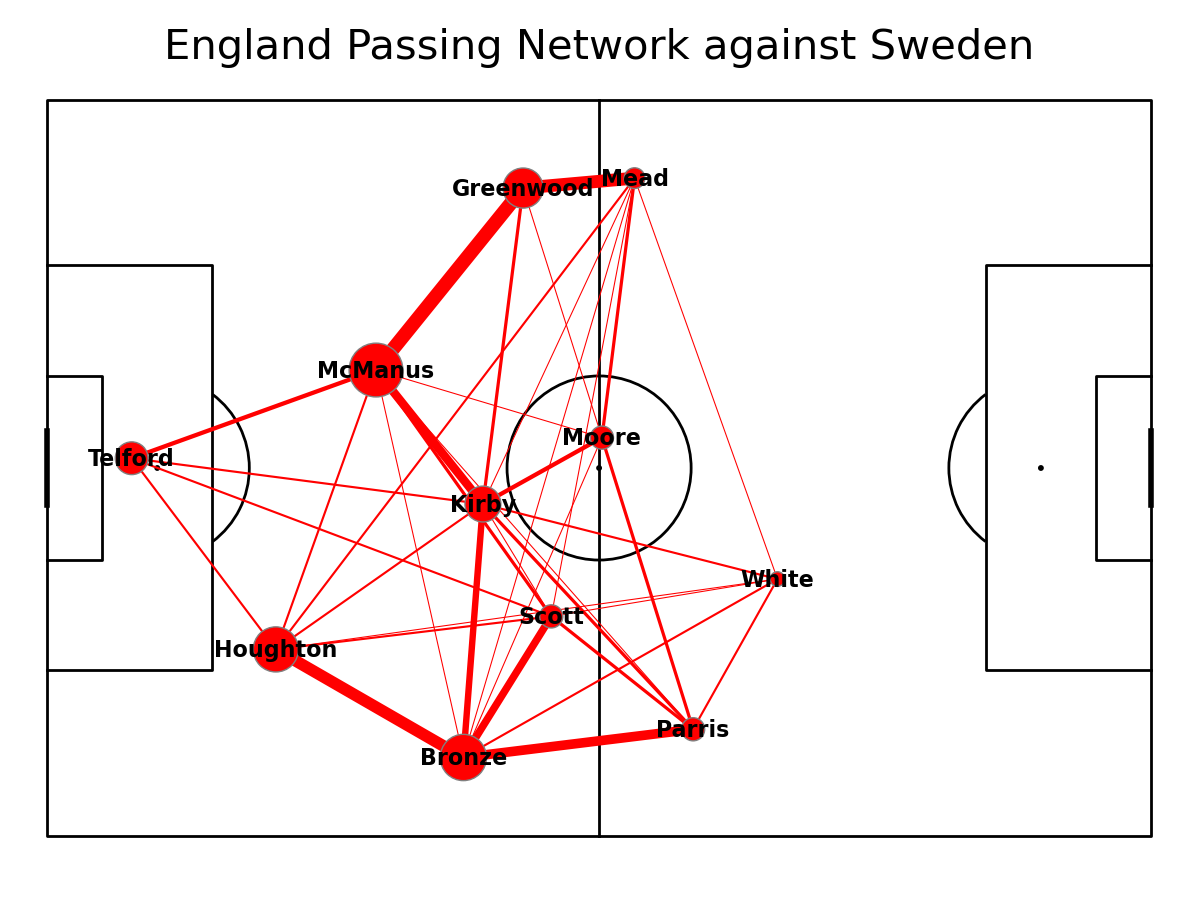

In [19]:
pitch = Pitch(line_color = 'black')
fig, ax = pitch.grid(grid_height = 0.9, title_height = 0.06, axis = False,
                     endnote_height = 0.04, title_space = 0, endnote_space = 0)

# scatter location on the pitch
pitch.scatter(scatter_df['x'], scatter_df['y'], s = scatter_df.marker_size, color = 'red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row["player_name"], xy=(row.x, row.y), c = 'black', va = 'center', ha = 'center', weight = "bold", size = 16, ax = ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]

    # get player1 and player2 locations to plot a line between them
    player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]

    # more passes = wider line
    line_width = (num_passes / lines_df['pass_count'].max() * 10)

    # plot lines
    pitch.lines(player1_x, player1_y, player2_x, player2_y, alpha = 1, lw = line_width, zorder = 2, color = "red", ax = ax["pitch"])

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()

From this network, we can conclude that McManus, Houghton, and Bronze were important players in England's buildout in this match. They received the most passes going forward, which implies that they were key players to advancing their possession. The heavier amounts of forward passes on the right suggests that England favored the right side of the field for their attack during this match, possibly due to a weak Sweden defender. The formation here appears to be a 4-3-3, with the defensive line being essential to buildout and put the ball on Moore or White's foot.